In [1]:
import keras
import quandl
import numpy as np

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import keras.backend as K
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = quandl.get('BCHARTS/BITFINEXUSD')

In [3]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2013-03-31,93.250000,100.000000,93.03000,93.100000,390.827224,3.708933e+04,94.899563
2013-04-01,93.170000,105.900000,92.49999,102.370000,4919.654127,4.921010e+05,100.027564
2013-04-02,102.800000,118.388067,99.00000,117.989990,9084.832816,9.874119e+05,108.687953
2013-04-03,116.579097,146.880000,101.51088,134.952969,12909.402178,1.652092e+06,127.975861
2013-04-04,131.779686,143.000000,119.00000,132.681000,6910.100414,9.094385e+05,131.610029


In [4]:
print(data.shape)
#1363,7

mean = data.mean(axis=0)
std = data.std(axis=0)

# normalizando os dados (zscore normalization)
data = ( data - mean ) / std

X = np.zeros((1363,6,7))

#deslocamento
d = 6

#tirando as d primeiras linhas que estao vazias por causa do deslocamento
for i in range(d,data.shape[0]):
    X[i,:,:] = data.iloc[i-d:i].values

#tirando as d primeiras linhas q tao vazias
X = X[d:,:,:]

print(X.shape)

(1363, 7)
(1357, 6, 7)


In [5]:
# criando as labels
Y = data['Weighted Price'] - data.shift(1)['Weighted Price']

Y.shape

(1363,)

In [6]:
Y = Y > 0

#retirando a primeira linha, pois a segunda label refere-se ao primeiro registro (variacao)
Y = Y[1:]

#retirando as d primeiras datas por causa do deslocamento
Y = Y[d:]

In [7]:
#retirando o ultimo registro das features para 
#especificando as outras dimensoes por boas praticas (nao esquecer a matriz)
X = X[: -1,:,:]

In [8]:
# conferindo os chapes
Y.shape, X.shape

((1356,), (1356, 6, 7))

In [9]:
# passando pro formato de 4 dimensoes esperadas
X = X.reshape((1356,6,7,1))

In [10]:
# train / test split
X_train = X[:-300,:,:,:]
X_test = X[-300:,:,:,:]
Y_train = Y[:-300]
Y_test = Y[-300:]

In [16]:
def model(input_shape):
    
    X_input = Input(input_shape)
    
    #padding same pra nao reduzir 
    X = Conv2D(10,(3,3), strides=(1,1),name="conv0", padding="same")(X_input)
    X = BatchNormalization(axis=3,name='bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool0')(X)
    
    #Second conv
    X = Conv2D(30,(2,2), strides=(1,1),name="conv1", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn1')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool1')(X)
    
    #Third conv
    #X = Conv2D(50,(1,1), strides=(1,1),name="conv2", padding="same")(X)
    #X = BatchNormalization(axis=3,name='bn2')(X)
    #X = Activation('relu')(X)
    
    #fcs
    X = Flatten()(X)
    X = Dense(200,activation="relu")(X)
    X = Dense(100,activation="relu")(X)
    X = Dense(50,activation="relu")(X)
    X = Dense(1,activation="sigmoid")(X)
    
    model = Model(inputs=X_input,outputs=X, name="model1")
    
    return model

In [17]:
#instanciando modelo
model = model(X[0].shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

model.fit(x = X_train, y = Y_train, epochs = 200, batch_size = 8)

Epoch 1/200
1056/1056 [==============================] - 1s 746us/step - loss: 0.7030 - acc: 0.5265
Epoch 2/200
1056/1056 [==============================] - 1s 509us/step - loss: 0.6948 - acc: 0.5256
Epoch 3/200
1056/1056 [==============================] - 1s 494us/step - loss: 0.6906 - acc: 0.5426
Epoch 4/200
1056/1056 [==============================] - 1s 499us/step - loss: 0.6902 - acc: 0.5369
Epoch 5/200
1056/1056 [==============================] - 1s 489us/step - loss: 0.6903 - acc: 0.5407
Epoch 6/200
1056/1056 [==============================] - 1s 493us/step - loss: 0.6888 - acc: 0.5511
Epoch 7/200
1056/1056 [==============================] - 1s 495us/step - loss: 0.6856 - acc: 0.5729
Epoch 8/200
1056/1056 [==============================] - 1s 494us/step - loss: 0.6832 - acc: 0.5710
Epoch 9/200
1056/1056 [==============================] - 1s 492us/step - loss: 0.6844 - acc: 0.5530
Epoch 10/200
1056/1056 [==============================] - 1s 498us/step - loss: 0.6838 - acc: 0.5616

1056/1056 [==============================] - ETA: 0s - loss: 0.3767 - acc: 0.804 - 1s 494us/step - loss: 0.3821 - acc: 0.8002
Epoch 83/200
1056/1056 [==============================] - 1s 517us/step - loss: 0.3752 - acc: 0.8106
Epoch 84/200
1056/1056 [==============================] - 0s 473us/step - loss: 0.3616 - acc: 0.8182
Epoch 85/200
1056/1056 [==============================] - 1s 594us/step - loss: 0.3425 - acc: 0.8172
Epoch 86/200
1056/1056 [==============================] - 1s 482us/step - loss: 0.3716 - acc: 0.8040
Epoch 87/200
1056/1056 [==============================] - 1s 492us/step - loss: 0.4042 - acc: 0.7888
Epoch 88/200
1056/1056 [==============================] - 1s 487us/step - loss: 0.3394 - acc: 0.8210
Epoch 89/200
1056/1056 [==============================] - 1s 562us/step - loss: 0.3314 - acc: 0.8277
Epoch 90/200
1056/1056 [==============================] - 1s 592us/step - loss: 0.3343 - acc: 0.8258
Epoch 91/200
1056/1056 [==============================] - 1s 502us

1056/1056 [==============================] - 1s 505us/step - loss: 0.3307 - acc: 0.8523
Epoch 163/200
1056/1056 [==============================] - 1s 479us/step - loss: 0.2777 - acc: 0.8532
Epoch 164/200
1056/1056 [==============================] - 1s 484us/step - loss: 0.2512 - acc: 0.8655
Epoch 165/200
1056/1056 [==============================] - 1s 485us/step - loss: 0.2427 - acc: 0.8741
Epoch 166/200
1056/1056 [==============================] - 1s 494us/step - loss: 0.2450 - acc: 0.8722
Epoch 167/200
1056/1056 [==============================] - 1s 515us/step - loss: 0.2340 - acc: 0.8741
Epoch 168/200
1056/1056 [==============================] - 1s 475us/step - loss: 0.2480 - acc: 0.8797
Epoch 169/200
1056/1056 [==============================] - 1s 478us/step - loss: 0.2664 - acc: 0.8504
Epoch 170/200
1056/1056 [==============================] - 1s 485us/step - loss: 0.2514 - acc: 0.8741
Epoch 171/200
1056/1056 [==============================] - 1s 503us/step - loss: 0.2637 - acc: 0

In [19]:
preds = model.evaluate(x = X_test, y = Y_test)
print()
print("Loss = " + str(preds[0]))
print("Acc = " + str(preds[1]))

300/300 [==============================] - 0s 144us/step

Loss = 2.43820947091
Acc = 0.446666666667


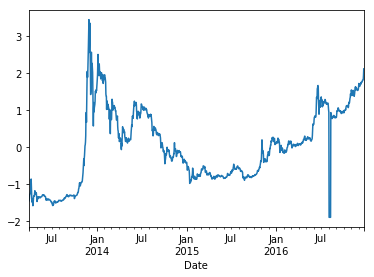

In [14]:
data['Weighted Price'].plot()